In [1]:
%load_ext autoreload
%autoreload 2

# Analysis 5
This analysis was edited from the opynfield tutorial. Here, we are comparing KMO and WT mice of three different age classes with males and females combined in the same group.

## 1. Import the package and needed functions / classes

In [2]:
from opynfield.config.user_input import UserInput
from opynfield.config.defaults_settings import Defaults
from opynfield.config.cov_asymptote import CoverageAsymptote
from opynfield.config.model_settings import set_up_fits
from opynfield.config.plot_settings import PlotSettings
from opynfield.readin.run_all import run_all_track_types
from opynfield.calculate_measures.calculate_measures import tracks_to_measures
from opynfield.summarize_measures.summarize_individuals import individual_measures_to_dfs
from opynfield.summarize_measures.summarize_groups import all_group_averages
from opynfield.fit_models.fit_individual_models import fit_all, find_fit_bounds, re_fit_all
from opynfield.fit_models.fit_group_models import group_fit_all
from opynfield.stat_test.stat_test import format_params, format_group_params, run_tests
from opynfield.plotting.plot_individuals import plot_all_individuals, plot_traces
from opynfield.plotting.plot_solo_groups import plot_all_solo_groups
from opynfield.plotting.plot_solo_groups_with_individuals import plot_components_of_solo_groups
from opynfield.plotting.plot_group_comparisons import plot_all_group_comparisons
from opynfield.readin.summary_file import summary_file
from opynfield.config.model_settings import LinearIncreaseModel, LinearDecreaseModel

from dataclasses import dataclass
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt

## 2. Define the settings to use

### 2a. Set up your user inputs

trim is a parameter that indicates how many recorded points should be deleted from the beginning of a trial. For this mouse dataset, the recorder is turned on before the mouse is placed in the arena, so we need to ignore the first data point that records the mouse while it is still outside of the arena.

In [3]:
user_settings = UserInput(groups_and_types = {"WT Young": ["AnyMaze Center"], "WT Middle Aged": ["AnyMaze Center"], "WT Old": ["AnyMaze Center"],
                                              "KMO Young": ["AnyMaze Center"], "KMO Middle Aged": ["AnyMaze Center"], "KMO Old": ["AnyMaze Center"]},
                          groups_to_paths = {"WT Young": "wty", "WT Middle Aged": "wtma", "WT Old": "wto",
                                             "KMO Young": "kmoy", "KMO Middle Aged": "kmoma", "KMO Old": "kmoo"},
                          arena_radius_cm = 18.5,
                          sample_freq = 5,
                          edge_dist_cm = 9.25, #mice exhibit less edge-dwelling behavior, but still spend ~90% of the time in the outer half of the arena
                          time_bin_size = 1,
                          inactivity_threshold = 0.001,
                          verbose = True,
                          result_path = '/Users/ellenmcmullen/Desktop/opynfield_v3_analysis_files/Analysis4/ExpectedResultsAnalysis4',
                          trim = 1)

### 2b. Prep the results directory

In [4]:
user_settings.prep_directory()

### 2c. Set up the default settings

In [5]:
default_settings = Defaults()

In [6]:
default_settings.time_averaged_measures = ['activity', 'coverage', 'percent_coverage',
                                            'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                            'p_zero_plus_given_zero', 'p_zero_zero_given_zero']
default_settings.coverage_averaged_measures = ['activity',
                                                'p_plus_plus_given_plus', 'p_plus_minus_given_plus', 'p_plus_zero_given_plus',
                                                'p_zero_plus_given_zero', 'p_zero_zero_given_zero']

### 2d. Set up the coverage asymptote settings

In [7]:
asymptote_settings = CoverageAsymptote()

### 2e. Set up the model settings

set_up_fits is a utility function to create a nested dictionary structure, but is filled with the default models to be used. Here, we need to change the models being used for many of the relationships to a linear increase or linear decrease model.

In [8]:
model_settings = set_up_fits()

In [9]:
# change models with the motion probabilities to linear models

model_settings['time']['p_plus_plus'].model = LinearDecreaseModel
model_settings['time']['p_plus_minus'].model = LinearIncreaseModel
model_settings['time']['p_plus_zero'].model = LinearIncreaseModel
model_settings['time']['p_zero_plus'].model = LinearDecreaseModel
model_settings['time']['p_zero_zero'].model = LinearIncreaseModel
model_settings['time']['p_plus_plus_given_plus'].model = LinearDecreaseModel
model_settings['time']['p_plus_minus_given_plus'].model = LinearIncreaseModel
model_settings['time']['p_plus_zero_given_plus'].model = LinearIncreaseModel
model_settings['time']['p_zero_plus_given_zero'].model = LinearDecreaseModel
model_settings['time']['p_zero_zero_given_zero'].model = LinearIncreaseModel
model_settings['time']['p_plus_plus_given_any'].model = LinearDecreaseModel
model_settings['time']['p_plus_minus_given_any'].model = LinearIncreaseModel
model_settings['time']['p_plus_zero_given_any'].model = LinearIncreaseModel
model_settings['time']['p_zero_plus_given_any'].model = LinearDecreaseModel
model_settings['time']['p_zero_zero_given_any'].model = LinearIncreaseModel

model_settings['coverage']['p_plus_plus'].model = LinearDecreaseModel
model_settings['coverage']['p_plus_minus'].model = LinearIncreaseModel
model_settings['coverage']['p_plus_zero'].model = LinearIncreaseModel
model_settings['coverage']['p_zero_plus'].model = LinearDecreaseModel
model_settings['coverage']['p_zero_zero'].model = LinearIncreaseModel
model_settings['coverage']['p_plus_plus_given_plus'].model = LinearDecreaseModel
model_settings['coverage']['p_plus_minus_given_plus'].model = LinearIncreaseModel
model_settings['coverage']['p_plus_zero_given_plus'].model = LinearIncreaseModel
model_settings['coverage']['p_zero_plus_given_zero'].model = LinearDecreaseModel
model_settings['coverage']['p_zero_zero_given_zero'].model = LinearIncreaseModel
model_settings['coverage']['p_plus_plus_given_any'].model = LinearDecreaseModel
model_settings['coverage']['p_plus_minus_given_any'].model = LinearIncreaseModel
model_settings['coverage']['p_plus_zero_given_any'].model = LinearIncreaseModel
model_settings['coverage']['p_zero_plus_given_any'].model = LinearDecreaseModel
model_settings['coverage']['p_zero_zero_given_any'].model = LinearIncreaseModel

model_settings['pica']['p_plus_plus'].model = LinearDecreaseModel
model_settings['pica']['p_plus_minus'].model = LinearIncreaseModel
model_settings['pica']['p_plus_zero'].model = LinearIncreaseModel
model_settings['pica']['p_zero_plus'].model = LinearDecreaseModel
model_settings['pica']['p_zero_zero'].model = LinearIncreaseModel
model_settings['pica']['p_plus_plus_given_plus'].model = LinearDecreaseModel
model_settings['pica']['p_plus_minus_given_plus'].model = LinearIncreaseModel
model_settings['pica']['p_plus_zero_given_plus'].model = LinearIncreaseModel
model_settings['pica']['p_zero_plus_given_zero'].model = LinearDecreaseModel
model_settings['pica']['p_zero_zero_given_zero'].model = LinearIncreaseModel
model_settings['pica']['p_plus_plus_given_any'].model = LinearDecreaseModel
model_settings['pica']['p_plus_minus_given_any'].model = LinearIncreaseModel
model_settings['pica']['p_plus_zero_given_any'].model = LinearIncreaseModel
model_settings['pica']['p_zero_plus_given_any'].model = LinearDecreaseModel
model_settings['pica']['p_zero_zero_given_any'].model = LinearIncreaseModel

model_settings['pgca']['p_plus_plus'].model = LinearDecreaseModel
model_settings['pgca']['p_plus_minus'].model = LinearIncreaseModel
model_settings['pgca']['p_plus_zero'].model = LinearIncreaseModel
model_settings['pgca']['p_zero_plus'].model = LinearDecreaseModel
model_settings['pgca']['p_zero_zero'].model = LinearIncreaseModel
model_settings['pgca']['p_plus_plus_given_plus'].model = LinearDecreaseModel
model_settings['pgca']['p_plus_minus_given_plus'].model = LinearIncreaseModel
model_settings['pgca']['p_plus_zero_given_plus'].model = LinearIncreaseModel
model_settings['pgca']['p_zero_plus_given_zero'].model = LinearDecreaseModel
model_settings['pgca']['p_zero_zero_given_zero'].model = LinearIncreaseModel
model_settings['pgca']['p_plus_plus_given_any'].model = LinearDecreaseModel
model_settings['pgca']['p_plus_minus_given_any'].model = LinearIncreaseModel
model_settings['pgca']['p_plus_zero_given_any'].model = LinearIncreaseModel
model_settings['pgca']['p_zero_plus_given_any'].model = LinearDecreaseModel
model_settings['pgca']['p_zero_zero_given_any'].model = LinearIncreaseModel

model_settings['percent_coverage']['p_plus_plus'].model = LinearDecreaseModel
model_settings['percent_coverage']['p_plus_minus'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_plus_zero'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_zero_plus'].model = LinearDecreaseModel
model_settings['percent_coverage']['p_zero_zero'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_plus_plus_given_plus'].model = LinearDecreaseModel
model_settings['percent_coverage']['p_plus_minus_given_plus'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_plus_zero_given_plus'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_zero_plus_given_zero'].model = LinearDecreaseModel
model_settings['percent_coverage']['p_zero_zero_given_zero'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_plus_plus_given_any'].model = LinearDecreaseModel
model_settings['percent_coverage']['p_plus_minus_given_any'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_plus_zero_given_any'].model = LinearIncreaseModel
model_settings['percent_coverage']['p_zero_plus_given_any'].model = LinearDecreaseModel
model_settings['percent_coverage']['p_zero_zero_given_any'].model = LinearIncreaseModel

### 2f. Set up the plotting settings

In [10]:
plot_settings = PlotSettings(group_colors={"WT Young": "#CECECE", "WT Middle Aged": "#A559AA", "WT Old": "#59A89C",
                                           "KMO Young": "#F0C571", "KMO Middle Aged": "#E02B35", "KMO Old": "#082A54"},
                             fig_extension='.svg')

## 3. Read in your data

In [11]:
track_list = run_all_track_types(groups_and_types=user_settings.groups_and_types,
                                 verbose=user_settings.verbose,
                                 arena_radius_cm=user_settings.arena_radius_cm,
                                 running_window_length=user_settings.running_window_length,
                                 window_step_size=user_settings.window_step_size,
                                 sample_freq=user_settings.sample_freq,
                                 time_bin_size=user_settings.time_bin_size,
                                 trim=user_settings.trim)

['AnyMaze Center']
{'AnyMaze Center': ['WT Young', 'WT Middle Aged', 'WT Old', 'KMO Young', 'KMO Middle Aged', 'KMO Old']}
Read In AnyMaze Center Files For Groups ['WT Young', 'WT Middle Aged', 'WT Old', 'KMO Young', 'KMO Middle Aged', 'KMO Old']
Running Anymaze Center Point Tracker Files For Group: WT Young
WT Young, File1 Out Of 33
Anymaze Center Point Track Converted To Numeric
Initial Time: 00:00:00.431000
AnyMaze Center Point Track Smoothed
AnyMaze Center Point Track Subsampled
AnyMaze Center Point Track Missing Values Filled
Combined Coordinate Center Point Calculated
AnyMaze Center Point Units Centered
WT Young, File2 Out Of 33
Anymaze Center Point Track Converted To Numeric
Initial Time: 00:00:00.352000
AnyMaze Center Point Track Smoothed
AnyMaze Center Point Track Subsampled
AnyMaze Center Point Track Missing Values Filled
Combined Coordinate Center Point Calculated
AnyMaze Center Point Units Centered
WT Young, File3 Out Of 33
Anymaze Center Point Track Converted To Numeric
In

In [12]:
# trim some tracks down to 10min if they went over
for track in track_list:
    if len(track.x) >= 600:
        track.x = track.x[0:600]
        track.y = track.y[0:600]
        track.t = track.t[0:600]

## 4. Calculate behavioral measures

### 4a. Generate the measures

In [13]:
standard_track_list, tracks_by_groups = tracks_to_measures(all_tracks=track_list,
                                                           user_config=user_settings,
                                                           default_settings=default_settings,
                                                           coverage_settings=asymptote_settings)

Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activity Calculated
Turning Angles Calculated
Motion Probabilities Calculated
Coverage Bins Located
Coverage Calculated
Percent Coverage Calculated
PICA Calculated
Polar Coordinates Calculated
Activi

### 4b. Save the measures

In [14]:
individual_dfs = individual_measures_to_dfs(tracks_by_groups=tracks_by_groups,
                                            defaults=default_settings,
                                            user_inputs=user_settings)

Summarizing Tracks From Group WT Young
Summarizing Tracks From Group WT Middle Aged
Summarizing Tracks From Group WT Old
Summarizing Tracks From Group KMO Young
Summarizing Tracks From Group KMO Middle Aged
Summarizing Tracks From Group KMO Old


### 4c. Calculate group averages of the measures

In [15]:
group_averages = all_group_averages(individual_measures_dfs=individual_dfs,
                                    test_defaults=default_settings,
                                    user_config=user_settings)

Averaging Tracks From Group WT Young by time
Averaging Tracks From Group WT Middle Aged by time
Averaging Tracks From Group WT Old by time
Averaging Tracks From Group KMO Young by time
Averaging Tracks From Group KMO Middle Aged by time
Averaging Tracks From Group KMO Old by time
Averaging Tracks From Group WT Young By coverage
Averaging Tracks From Group WT Middle Aged By coverage
Averaging Tracks From Group WT Old By coverage
Averaging Tracks From Group KMO Young By coverage
Averaging Tracks From Group KMO Middle Aged By coverage
Averaging Tracks From Group KMO Old By coverage
Averaging Tracks From Group WT Young By pica
Averaging Tracks From Group WT Middle Aged By pica
Averaging Tracks From Group WT Old By pica
Averaging Tracks From Group KMO Young By pica
Averaging Tracks From Group KMO Middle Aged By pica
Averaging Tracks From Group KMO Old By pica
Averaging Tracks From Group WT Young By pgca
Averaging Tracks From Group WT Middle Aged By pgca
Averaging Tracks From Group WT Old By

We can check out the plots of group averages to check that we specified the correct models.

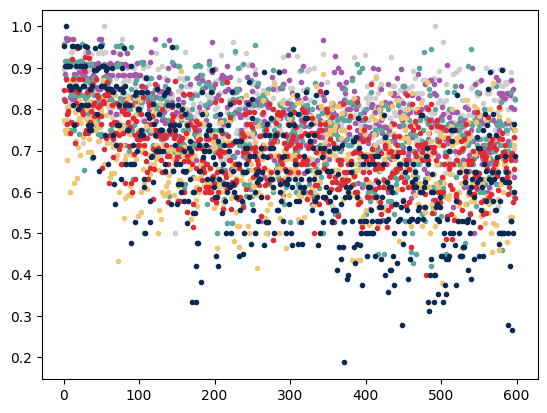

In [16]:
plt.plot(group_averages['time']['WT Young']['p_plus_plus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['time']['WT Middle Aged']['p_plus_plus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['time']['WT Old']['p_plus_plus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['time']['KMO Young']['p_plus_plus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['time']['KMO Middle Aged']['p_plus_plus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['time']['KMO Old']['p_plus_plus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#082A54')
plt.show()

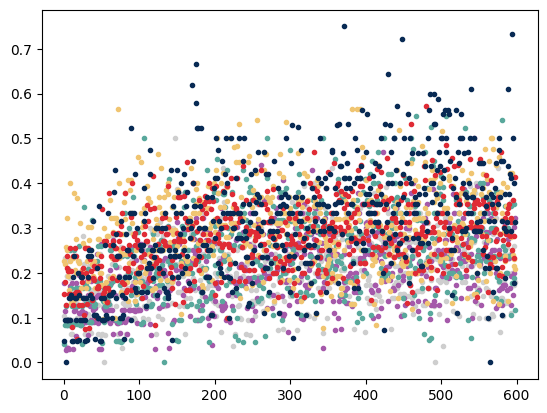

In [17]:
plt.plot(group_averages['time']['WT Young']['p_plus_minus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['time']['WT Middle Aged']['p_plus_minus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['time']['WT Old']['p_plus_minus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['time']['KMO Young']['p_plus_minus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['time']['KMO Middle Aged']['p_plus_minus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['time']['KMO Old']['p_plus_minus_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#082A54')
plt.show()

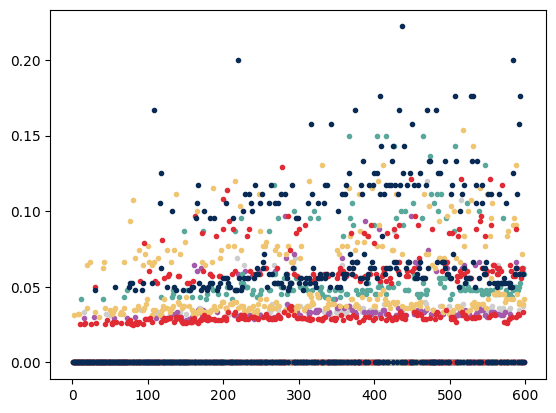

In [18]:
plt.plot(group_averages['time']['WT Young']['p_plus_zero_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['time']['WT Middle Aged']['p_plus_zero_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['time']['WT Old']['p_plus_zero_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['time']['KMO Young']['p_plus_zero_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['time']['KMO Middle Aged']['p_plus_zero_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['time']['KMO Old']['p_plus_zero_given_plus'].iloc[0][2:602], marker = '.', linestyle='None', c = '#082A54')
plt.show()

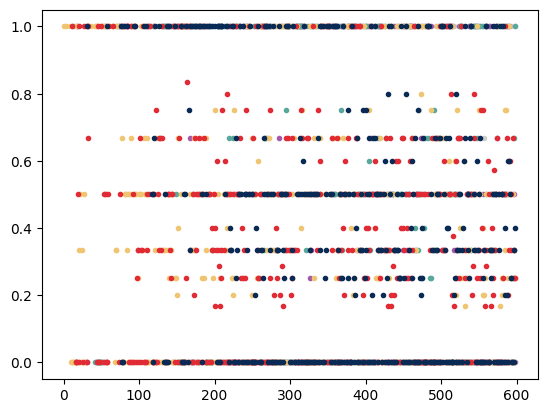

In [19]:
plt.plot(group_averages['time']['WT Young']['p_zero_plus_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['time']['WT Middle Aged']['p_zero_plus_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['time']['WT Old']['p_zero_plus_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['time']['KMO Young']['p_zero_plus_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['time']['KMO Middle Aged']['p_zero_plus_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['time']['KMO Old']['p_zero_plus_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#082A54')
plt.show()

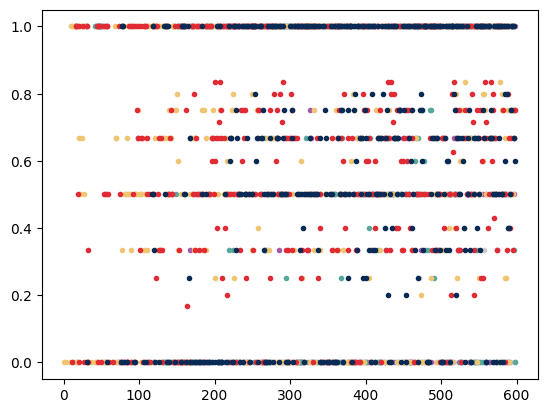

In [20]:
plt.plot(group_averages['time']['WT Young']['p_zero_zero_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['time']['WT Middle Aged']['p_zero_zero_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['time']['WT Old']['p_zero_zero_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['time']['KMO Young']['p_zero_zero_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['time']['KMO Middle Aged']['p_zero_zero_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['time']['KMO Old']['p_zero_zero_given_zero'].iloc[0][2:602], marker = '.', linestyle='None', c = '#082A54')
plt.show()

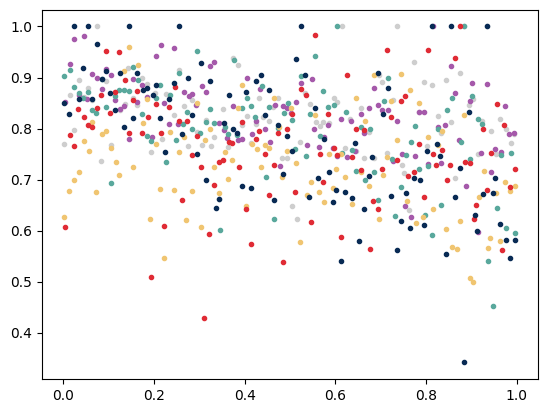

In [21]:
plt.plot(group_averages['percent_coverage']['WT Young']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Young']['p_plus_plus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['percent_coverage']['WT Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Middle Aged']['p_plus_plus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['percent_coverage']['WT Old']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Old']['p_plus_plus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['percent_coverage']['KMO Young']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Young']['p_plus_plus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['percent_coverage']['KMO Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Middle Aged']['p_plus_plus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['percent_coverage']['KMO Old']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Old']['p_plus_plus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#082A54')
plt.show()

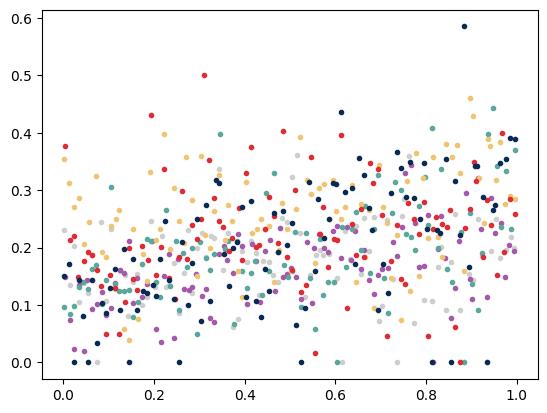

In [22]:
plt.plot(group_averages['percent_coverage']['WT Young']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Young']['p_plus_minus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['percent_coverage']['WT Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Middle Aged']['p_plus_minus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['percent_coverage']['WT Old']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Old']['p_plus_minus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['percent_coverage']['KMO Young']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Young']['p_plus_minus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['percent_coverage']['KMO Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Middle Aged']['p_plus_minus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['percent_coverage']['KMO Old']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Old']['p_plus_minus_given_plus mean'], 
         marker = '.', linestyle='None', c = '#082A54')
plt.show()

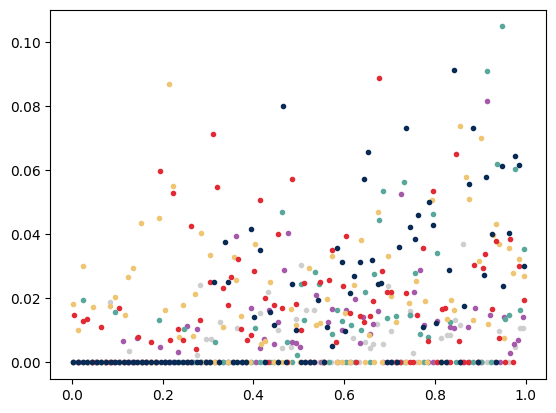

In [23]:
plt.plot(group_averages['percent_coverage']['WT Young']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Young']['p_plus_zero_given_plus mean'], 
         marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['percent_coverage']['WT Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Middle Aged']['p_plus_zero_given_plus mean'], 
         marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['percent_coverage']['WT Old']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Old']['p_plus_zero_given_plus mean'], 
         marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['percent_coverage']['KMO Young']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Young']['p_plus_zero_given_plus mean'], 
         marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['percent_coverage']['KMO Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Middle Aged']['p_plus_zero_given_plus mean'], 
         marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['percent_coverage']['KMO Old']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Old']['p_plus_zero_given_plus mean'], 
         marker = '.', linestyle='None', c = '#082A54')
plt.show()

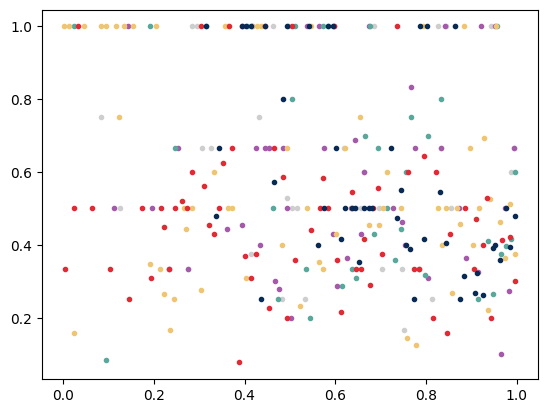

In [24]:
plt.plot(group_averages['percent_coverage']['WT Young']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Young']['p_zero_plus_given_zero mean'], 
         marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['percent_coverage']['WT Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Middle Aged']['p_zero_plus_given_zero mean'], 
         marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['percent_coverage']['WT Old']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Old']['p_zero_plus_given_zero mean'], 
         marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['percent_coverage']['KMO Young']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Young']['p_zero_plus_given_zero mean'], 
         marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['percent_coverage']['KMO Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Middle Aged']['p_zero_plus_given_zero mean'], 
         marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['percent_coverage']['KMO Old']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Old']['p_zero_plus_given_zero mean'], 
         marker = '.', linestyle='None', c = '#082A54')
plt.show()

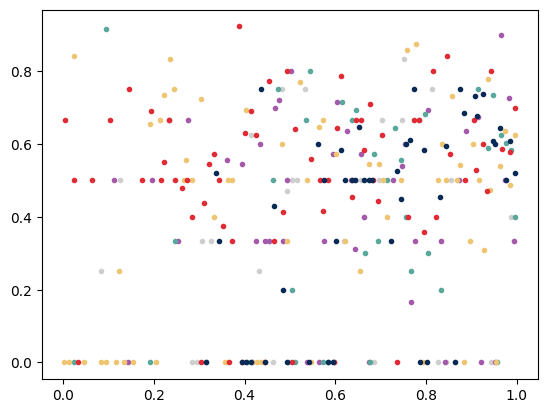

In [25]:
plt.plot(group_averages['percent_coverage']['WT Young']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Young']['p_zero_zero_given_zero mean'], 
         marker = '.', linestyle='None', c = '#CECECE')
plt.plot(group_averages['percent_coverage']['WT Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Middle Aged']['p_zero_zero_given_zero mean'], 
         marker = '.', linestyle='None', c = '#A559AA')
plt.plot(group_averages['percent_coverage']['WT Old']['percent_coverage mean'],
         group_averages['percent_coverage']['WT Old']['p_zero_zero_given_zero mean'], 
         marker = '.', linestyle='None', c = '#59A89C')
plt.plot(group_averages['percent_coverage']['KMO Young']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Young']['p_zero_zero_given_zero mean'], 
         marker = '.', linestyle='None', c = '#F0C571')
plt.plot(group_averages['percent_coverage']['KMO Middle Aged']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Middle Aged']['p_zero_zero_given_zero mean'], 
         marker = '.', linestyle='None', c = '#E02B35')
plt.plot(group_averages['percent_coverage']['KMO Old']['percent_coverage mean'],
         group_averages['percent_coverage']['KMO Old']['p_zero_zero_given_zero mean'], 
         marker = '.', linestyle='None', c = '#082A54')
plt.show()

## 5. Fit models to individuals' measures

### 5a. Naive bounds

In [26]:
naive_fits = fit_all(individual_measures_dfs=individual_dfs,
                     defaults=default_settings,
                     model_params=model_settings)

Fitting Models To Tracks From Group WT Young by time
Fitting Models To Tracks From Group WT Young by coverage
Fitting Models To Tracks From Group WT Young by pica
Fitting Models To Tracks From Group WT Young by pgca
Fitting Models To Tracks From Group WT Young by percent_coverage
Fitting Models To Tracks From Group WT Middle Aged by time
Fitting Models To Tracks From Group WT Middle Aged by coverage
Fitting Models To Tracks From Group WT Middle Aged by pica
Fitting Models To Tracks From Group WT Middle Aged by pgca
Fitting Models To Tracks From Group WT Middle Aged by percent_coverage
Fitting Models To Tracks From Group WT Old by time
Fitting Models To Tracks From Group WT Old by coverage
Fitting Models To Tracks From Group WT Old by pica
Fitting Models To Tracks From Group WT Old by pgca
Fitting Models To Tracks From Group WT Old by percent_coverage
Fitting Models To Tracks From Group KMO Young by time
Fitting Models To Tracks From Group KMO Young by coverage
Fitting Models To Tracks 

### 5b. Find new bounds

### 5b. Find new bounds

In [27]:
upper_bounds, lower_bounds, p0s = find_fit_bounds(fits=naive_fits,
                                                  user_inputs=user_settings)

### 5c. Re-fit models

In [28]:
bounded_fits = re_fit_all(individual_measures_dfs=individual_dfs,
                          defaults=default_settings,
                          model_params=model_settings,
                          upper=upper_bounds,
                          lower=lower_bounds,
                          initial=p0s )

Re-Fitting Models To Tracks From Group WT Young by time
Re-Fitting Models To Tracks From Group WT Young by coverage
Re-Fitting Models To Tracks From Group WT Young by pica
Re-Fitting Models To Tracks From Group WT Young by pgca
Re-Fitting Models To Tracks From Group WT Young by percent_coverage


/Users/ellenmcmullen/opt/anaconda3/envs/opynfield_curr/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:161: RuntimeWarning: invalid value encountered in divide
  p = -V.dot(suf / (s**2 + alpha))
/Users/ellenmcmullen/opt/anaconda3/envs/opynfield_curr/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)


Re-Fitting Models To Tracks From Group WT Middle Aged by time
Re-Fitting Models To Tracks From Group WT Middle Aged by coverage
Re-Fitting Models To Tracks From Group WT Middle Aged by pica
Re-Fitting Models To Tracks From Group WT Middle Aged by pgca
Re-Fitting Models To Tracks From Group WT Middle Aged by percent_coverage
Re-Fitting Models To Tracks From Group WT Old by time
Re-Fitting Models To Tracks From Group WT Old by coverage
Re-Fitting Models To Tracks From Group WT Old by pica
Re-Fitting Models To Tracks From Group WT Old by pgca
Re-Fitting Models To Tracks From Group WT Old by percent_coverage
Re-Fitting Models To Tracks From Group KMO Young by time
Re-Fitting Models To Tracks From Group KMO Young by coverage
Re-Fitting Models To Tracks From Group KMO Young by pica
Re-Fitting Models To Tracks From Group KMO Young by pgca
Re-Fitting Models To Tracks From Group KMO Young by percent_coverage
Re-Fitting Models To Tracks From Group KMO Middle Aged by time
Re-Fitting Models To Tra

### 5d. Format and save the bounded individual fits

In [29]:
formatted_bounded_fits = format_params(bounded_fits=deepcopy(bounded_fits),
                                       defaults=default_settings,
                                       user_inputs=user_settings)

## 6. Fit models to group measures

### 6a. Fit the group models with bounds

In [30]:
group_fits = group_fit_all(individual_measures_dfs=individual_dfs,
                           defaults=default_settings,
                           model_params=model_settings,
                           upper=upper_bounds,
                           lower=lower_bounds,
                           initial=p0s)

Fitting Models To Entire Group WT Young by time
Fitting Models To Entire Group WT Young by coverage
Fitting Models To Entire Group WT Young by pica
Fitting Models To Entire Group WT Young by pgca
Fitting Models To Entire Group WT Young by percent_coverage
Fitting Models To Entire Group WT Middle Aged by time
Fitting Models To Entire Group WT Middle Aged by coverage
Fitting Models To Entire Group WT Middle Aged by pica
Fitting Models To Entire Group WT Middle Aged by pgca
Fitting Models To Entire Group WT Middle Aged by percent_coverage
Fitting Models To Entire Group WT Old by time
Fitting Models To Entire Group WT Old by coverage
Fitting Models To Entire Group WT Old by pica
Fitting Models To Entire Group WT Old by pgca
Fitting Models To Entire Group WT Old by percent_coverage
Fitting Models To Entire Group KMO Young by time
Fitting Models To Entire Group KMO Young by coverage
Fitting Models To Entire Group KMO Young by pica
Fitting Models To Entire Group KMO Young by pgca
Fitting Mode

### 6b. Format and save the bounded group fits

In [31]:
format_group_params(group_fits=deepcopy(group_fits),
                    defaults=default_settings,
                    user_inputs=user_settings)

## 7. Run statistical tests

In [32]:
run_tests(formatted_bounded_fits=formatted_bounded_fits,
          defaults=default_settings,
          user_inputs=user_settings)

## 8. Plot the results

### 8a. Plot individuals

In [33]:
plot_all_individuals(measures=individual_dfs,
                     model_params=bounded_fits,
                     model_info=model_settings,
                     defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Individuals From Group WT Young by time
Plotting Individuals From Group WT Young by coverage
Plotting Individuals From Group WT Young by pica
Plotting Individuals From Group WT Young by pgca
Plotting Individuals From Group WT Young by percent_coverage
Plotting Individuals From Group WT Middle Aged by time
Plotting Individuals From Group WT Middle Aged by coverage
Plotting Individuals From Group WT Middle Aged by pica
Plotting Individuals From Group WT Middle Aged by pgca
Plotting Individuals From Group WT Middle Aged by percent_coverage
Plotting Individuals From Group WT Old by time
Plotting Individuals From Group WT Old by coverage
Plotting Individuals From Group WT Old by pica
Plotting Individuals From Group WT Old by pgca
Plotting Individuals From Group WT Old by percent_coverage
Plotting Individuals From Group KMO Young by time
Plotting Individuals From Group KMO Young by coverage
Plotting Individuals From Group KMO Young by pica
Plotting Individuals From Group KMO Young b

### 8b. Plot traces

In [34]:
plot_traces(tracks_by_groups=tracks_by_groups,
            plot_settings=plot_settings,
            user_input=user_settings)

### 8c. Plot group averages

In [35]:
plot_all_solo_groups(group_averages=group_averages,
                     group_fits=group_fits,
                     model_params=model_settings,
                     test_defaults=default_settings,
                     plot_settings=plot_settings,
                     user_config=user_settings)

Plotting Group WT Young by time
Plotting Group WT Young by coverage
Plotting Group WT Young by pica
Plotting Group WT Young by pgca
Plotting Group WT Young by percent_coverage
Plotting Group WT Middle Aged by time
Plotting Group WT Middle Aged by coverage
Plotting Group WT Middle Aged by pica
Plotting Group WT Middle Aged by pgca
Plotting Group WT Middle Aged by percent_coverage
Plotting Group WT Old by time
Plotting Group WT Old by coverage
Plotting Group WT Old by pica
Plotting Group WT Old by pgca
Plotting Group WT Old by percent_coverage
Plotting Group KMO Young by time
Plotting Group KMO Young by coverage
Plotting Group KMO Young by pica
Plotting Group KMO Young by pgca
Plotting Group KMO Young by percent_coverage
Plotting Group KMO Middle Aged by time
Plotting Group KMO Middle Aged by coverage
Plotting Group KMO Middle Aged by pica
Plotting Group KMO Middle Aged by pgca
Plotting Group KMO Middle Aged by percent_coverage
Plotting Group KMO Old by time
Plotting Group KMO Old by cov

### 8d. Plot group averages with component individuals

In [36]:
plot_components_of_solo_groups(individuals=individual_dfs,
                               individual_fits=bounded_fits,
                               groups=group_averages,
                               group_fits=group_fits,
                               model_specs=model_settings,
                               defaults=default_settings,
                               plot_settings=plot_settings,
                               user_inputs=user_settings)

Plotting Group And Individuals of WT Young by time
Plotting Group And Individuals of WT Young by coverage
Plotting Group And Individuals of WT Young by pica
Plotting Group And Individuals of WT Young by pgca
Plotting Group And Individuals of WT Young by percent_coverage
Plotting Group And Individuals of WT Middle Aged by time
Plotting Group And Individuals of WT Middle Aged by coverage
Plotting Group And Individuals of WT Middle Aged by pica
Plotting Group And Individuals of WT Middle Aged by pgca
Plotting Group And Individuals of WT Middle Aged by percent_coverage
Plotting Group And Individuals of WT Old by time
Plotting Group And Individuals of WT Old by coverage
Plotting Group And Individuals of WT Old by pica
Plotting Group And Individuals of WT Old by pgca
Plotting Group And Individuals of WT Old by percent_coverage
Plotting Group And Individuals of KMO Young by time
Plotting Group And Individuals of KMO Young by coverage
Plotting Group And Individuals of KMO Young by pica
Plottin

### 8e. Plot group average comparisons

In [37]:
plot_all_group_comparisons(group_averages=group_averages,
                           group_fits=group_fits,
                           model_params=model_settings,
                           test_defaults=default_settings,
                           plot_settings=plot_settings,
                           user_config=user_settings)

Plotting Group Comparisons by time
Plotting Group Comparisons by coverage
Plotting Group Comparisons by pica
Plotting Group Comparisons by pgca
Plotting Group Comparisons by percent_coverage


## 9. Summarize the run

In [38]:
summary_file(tracks_by_group=tracks_by_groups,
             test_cov_asymptote=asymptote_settings,
             user_defaults=default_settings,
             model_settings=model_settings,
             plot_settings=plot_settings,
             user_config=user_settings)

Formatting Summary File


## You're done!